### 타다 금지법 동영상 댓글 분석
#### KoNLPy를 사용

### 공식 사이트
#### https://konlpy-ko.readthedocs.io/ko/v0.5.2/

- ubuntu 기준 설치

    `sudo apt-get install g++ openjdk-8-jdk python3-dev python3-pip curl`
    
    `python3 -m pip install konlpy`
    
    
- 윈도우 기준 설치

    `pip install --upgrade pip`

    `pip install JPype1-0.5.7-cp27-none-win_amd64.whl`

    `pip install konlpy`
    
    
    
- 분석 방법
    - MongoDB 에서 데이터 가져오기
    - df 변환하고 샘플 뽑기
    - df 파일 텍스트 파일로 변환
    - 단어, 단어 빈도수, 형태소 추출
    - 중복 : 라인(문장별), 단어별 확인
    - 중복 단어, 특정 제거 기준에 따라 단어 처리
    - 최종 빈도수 파악
    - 워드 크라우드, 그래프 시각화
    
    
    
- 변수 설명
    - comment_result : 몽고 디비에서 가져온 df 변수
    - comment_sample : 댓글 상위 10개 샘플
    - wtest_samlpe.txt 샘플 텍스트 파일
    - com_txt : 텍스트 파일로 변환한 변수(wtest_samlpe.txt 사용)
    - word_ext : 단어 추출(com_txt 사용)
    - word_freq : 단어 빈도(word_ext 사용) 
    - duplicate_comment : 동일 단어 제거(com_txt 사용)
    - duplicate_comment_freq : 문장 별 중복 단어 제거, 빈도수 확인
    - rm_dupl : 두 단어 이상 글자 선택(워드크라우드, 그래프 그릴 때 사용되는 원본 데이터)
    - result_freq_mc_dict : 단어별 최종 빈도수


In [112]:
#package import
from konlpy.tag import * # konlpy 한글 분석용
from wordcloud import WordCloud

import matplotlib
import matplotlib.pyplot as plt
from matplotlib import font_manager, rc # 폰트 폰트...ㅠ

from collections import Counter # 빈도 분석
import pandas as pd

import pymongo


okt = Okt()
kkma = Kkma()

In [23]:
# 몽고DB에서 데이터 가져오기
client = pymongo.MongoClient("mongodb://id:pw@ip.ip.ip.ip:port/")
result = client.crawling.youtube
comment_result = pd.DataFrame(result.find({}))
comment_result.tail()

,_id,user_id,댓글,제목,좋아요 수
185,5e6e7304899b7f253dd60d7a,고래밥,타다는 참 어려운 주제인거 같은데 그나마 갓주니가 풀어줘서 좀 더 잘 이해를 하게 ...,"[KBS열린토론] 타다 금지법 이후, 차량 공유서비스는 어디로? / 정준희, 구태언...",
186,5e6e7304899b7f253dd60d7b,kiyomaru Suzuki,타다가 1년반동안 누적적자 300억이라면 택시 밀어낸 후 결국 요금인상으로 이어지겠네,"[KBS열린토론] 타다 금지법 이후, 차량 공유서비스는 어디로? / 정준희, 구태언...",
187,5e6e7304899b7f253dd60d7c,용덕,패널선택이불공편하네요\n타다옹호하려구나왔나\n케이비에스가 타다살려주려구\n토론주제를...,"[KBS열린토론] 타다 금지법 이후, 차량 공유서비스는 어디로? / 정준희, 구태언...",
188,5e6e7304899b7f253dd60d7d,문성우,"박정희군사쿠데타, 전두환군사쿠데타국민학살, 박그네세월호 최서원 국정농단 최태민과 이...","[KBS열린토론] 타다 금지법 이후, 차량 공유서비스는 어디로? / 정준희, 구태언...",
189,5e6e7304899b7f253dd60d7e,김태구,그냥 개인 자격으로 참여한 분들로 봅시다.\n여튼 패널 선정은.완전 에러,"[KBS열린토론] 타다 금지법 이후, 차량 공유서비스는 어디로? / 정준희, 구태언...",


In [78]:
# 잘려서 보이지만 다 보임.
import sys
comment = list(comment_result['댓글'])
# 양이 많아 10개만
comment_sample = comment[0:10]
comment_sample

['사람들이 모르는 거...자가용 운전자가 자신이 아는 사람 태우고 갈 경우,  사고가 나면 승차인원 전원이 보험혜택을 받음.  헌데 흔히 나라시라고 모르는 사람을 태워줬을 경우, 돈을 받았건 안 받았건 사고 나면 운전자 본인 외에 보험혜택을 못 받음...카톡으로 같은 방향 태워주고 나누는 삶 좋은 삶이 아니라 사고 나도 보험 혜택을 못 받는 삶임.....이럴려면   택시면허증은 왜 발급하는데?',
 '기사가 운전하는 타다는 택시와 달리 승객의 지위가 서비스를 받는 손님이 아니라 기사를 고용한 고용주 입니다.  기사와 렌트카의 보상범위가 넘는 사고 유발시 문제가 발생 할 수 있죠.',
 '최소한의 규칙까지도 무너뜨리려는 행위\n하는짓들이 하나같이 문제투성이네요',
 '타다\n잘몰랐는데\n야메\n한방에 알았네요 ~~~꾸벅',
 '"타다" 잘 몰랐는데, 이쯤되면 \n타다 국정조사해야 되는 것 아닌가? \n뭔가 검은 돈이 오간 악취가 난다.',
 '타다법 법사위 통과는 불법편법을 4차산업이라는 말을 내세워 합법화처럼 운영하려했던 모호했던 법안을 정리한 합리적인 법이라고 본다.당연히 여객운송법으로 모든 사업자가 법에의해 사업을 하고있는데 랜터카의 모호한 법을 찾아내 마치 4차산업이란 말로 무임승차 하려던 타다법이 정리된건 잘된일이라 본다. \n죽긴 왜 죽냐 공꺼로 할려니깐 그렇지 제도권 총량제 틀속에서 하면 되잖아 면허를 사던지 그것도 아까우면 택시랑 가맹을 맺어서 하던지 그것도 싫으연 면허를 지입형태로 받아 들이고 임대료 주면서 기사 따로 고용을 해서 하던지 1세대 벤처 김희애 남편 이찬진이 그랬잖아 20대 국회서 가장 잘한일이 타다 금지법 법사위 통과한 거라고 본다. ',
 '같은뉴스 댓글 좋아요 누른것을보면요 다음은  좋아요가 10배 네이버는 싫어요가 5배되는데 이제는 트루킹이 다음으로 간듯합니다뉴스는 김경수가 100만원씩 주자고한것요',
 '이재웅이 친노돌과 짬짜미한 것으로\n의심됨',
 '공유합니다!  감사합니다',
 '타다금지법 통과\n너무 잘됐네요^^']

In [79]:
#NLP 분석 시 텍스트 형태로 불러와 작업해줘야 한다.
#파일 쓰는 함수
def write_txt(list,fname,sep):
    file = open(fname,'w')
    vstr = ''
    
    for a in list:
        vstr = vstr + str(a) + sep
    vstr = vstr.rstrip(sep)
    
    file.writelines(vstr)
    
    file.close()
    print('[complete]')

In [80]:
write_txt(comment_sample,'wtest_samlpe.txt',sep="'")

[complete]


In [81]:
com_txt = open('wtest_samlpe.txt').read()

In [82]:
# 추출된 단어 구하기
word_ext = okt.nouns(com_txt)
print(word_ext)

['사람', '거', '자가용', '운전자', '자신', '사람', '경우', '사고', '승차', '인원', '전원', '보험', '혜택', '나라시', '사람', '경우', '돈', '안', '사고', '운전자', '본인', '외', '보험', '혜택', '못', '카톡', '방향', '삶', '삶', '사고', '보험', '혜택', '못', '삶임', '택시', '면허증', '왜', '발급', '기사', '운전', '택시', '달리', '승객', '지위', '서비스', '손님', '기사', '고용', '고용주', '기사', '렌트카', '보상', '범위', '사고', '유발', '시', '문제', '발생', '수', '최소한', '규칙', '무너', '려', '행위', '투성이', '야메', '방', '꾸벅', '이쯤', '국정조사', '것', '뭔가', '돈', '악취', '법', '법', '사위', '통과', '불법', '편법', '차', '산업', '말', '합법', '운영', '법안', '정리', '합리', '법', '여객운송', '법', '모든', '사업자', '법', '해', '사업', '랜터카', '법', '마치', '차', '산업', '말로', '무임', '승차', '법', '정리', '일이', '왜', '공', '려', '제도', '총량제', '틀속', '면허', '그것', '택시', '가맹', '그것', '연', '면허', '입', '형태', '임대료', '기사', '고용', '세대', '처', '김희애', '남편', '이찬진', '국회', '가장', '일이', '금지법', '법', '사위', '통과', '거', '뉴스', '댓글', '다음', '요가', '배', '네이버', '요가', '배', '이제', '트루', '킹', '다음', '뉴스', '김경수', '자고', '것', '이재웅', '친노', '돌', '짬짜미', '것', '의심', '공유', '금지법', '통과']


In [83]:
# 추출 단어 빈도수 구하기
word_freq = Counter(word_ext)
print(word_freq)
# 결과를 보니 생각보다 별로다... 전체 결과를 보았을 때는 타다 언급이 가장 많았음.

Counter({'법': 8, '사고': 4, '기사': 4, '사람': 3, '보험': 3, '혜택': 3, '택시': 3, '것': 3, '통과': 3, '거': 2, '운전자': 2, '경우': 2, '승차': 2, '돈': 2, '못': 2, '삶': 2, '왜': 2, '고용': 2, '려': 2, '사위': 2, '차': 2, '산업': 2, '정리': 2, '일이': 2, '면허': 2, '그것': 2, '금지법': 2, '뉴스': 2, '다음': 2, '요가': 2, '배': 2, '자가용': 1, '자신': 1, '인원': 1, '전원': 1, '나라시': 1, '안': 1, '본인': 1, '외': 1, '카톡': 1, '방향': 1, '삶임': 1, '면허증': 1, '발급': 1, '운전': 1, '달리': 1, '승객': 1, '지위': 1, '서비스': 1, '손님': 1, '고용주': 1, '렌트카': 1, '보상': 1, '범위': 1, '유발': 1, '시': 1, '문제': 1, '발생': 1, '수': 1, '최소한': 1, '규칙': 1, '무너': 1, '행위': 1, '투성이': 1, '야메': 1, '방': 1, '꾸벅': 1, '이쯤': 1, '국정조사': 1, '뭔가': 1, '악취': 1, '불법': 1, '편법': 1, '말': 1, '합법': 1, '운영': 1, '법안': 1, '합리': 1, '여객운송': 1, '모든': 1, '사업자': 1, '해': 1, '사업': 1, '랜터카': 1, '마치': 1, '말로': 1, '무임': 1, '공': 1, '제도': 1, '총량제': 1, '틀속': 1, '가맹': 1, '연': 1, '입': 1, '형태': 1, '임대료': 1, '세대': 1, '처': 1, '김희애': 1, '남편': 1, '이찬진': 1, '국회': 1, '가장': 1, '댓글': 1, '네이버': 1, '이제': 1, '트루': 1, '킹': 1, '김경수': 1, '자고': 1, '

In [84]:
# 명사, 조사 각 품사들 찾아내기
okt.pos(com_txt, join=True)

['사람/Noun',
 '들/Suffix',
 '이/Josa',
 '모르는/Verb',
 '거/Noun',
 '.../Punctuation',
 '자가용/Noun',
 '운전자/Noun',
 '가/Josa',
 '자신/Noun',
 '이/Josa',
 '아는/Verb',
 '사람/Noun',
 '태우고/Verb',
 '갈/Verb',
 '경우/Noun',
 ',/Punctuation',
 '사고/Noun',
 '가/Josa',
 '나면/Verb',
 '승차/Noun',
 '인원/Noun',
 '전원/Noun',
 '이/Josa',
 '보험/Noun',
 '혜택/Noun',
 '을/Josa',
 '받음/Verb',
 './Punctuation',
 '헌데/Verb',
 '흔히/Adjective',
 '나라시/Noun',
 '라고/Josa',
 '모르는/Verb',
 '사람/Noun',
 '을/Josa',
 '태워/Verb',
 '줬을/Verb',
 '경우/Noun',
 ',/Punctuation',
 '돈/Noun',
 '을/Josa',
 '받았건/Verb',
 '안/Noun',
 '받았건/Verb',
 '사고/Noun',
 '나면/Verb',
 '운전자/Noun',
 '본인/Noun',
 '외/Noun',
 '에/Josa',
 '보험/Noun',
 '혜택/Noun',
 '을/Josa',
 '못/Noun',
 '받음/Verb',
 '.../Punctuation',
 '카톡/Noun',
 '으로/Josa',
 '같은/Adjective',
 '방향/Noun',
 '태워주고/Verb',
 '나누는/Verb',
 '삶/Noun',
 '좋은/Adjective',
 '삶/Noun',
 '이/Josa',
 '아니라/Adjective',
 '사고/Noun',
 '나도/Verb',
 '보험/Noun',
 '혜택/Noun',
 '을/Josa',
 '못/Noun',
 '받는/Verb',
 '삶임/Noun',
 '...../Punctuation',
 '이럴려면/Adjective',


In [86]:
# 형태소 추출 하기. norm 은 문장 정규화 stem 은 어간 추출
print(okt.morphs(com_txt, norm=True))

['사람', '들', '이', '모르는', '거', '...', '자가용', '운전자', '가', '자신', '이', '아는', '사람', '태우고', '갈', '경우', ',', '사고', '가', '나면', '승차', '인원', '전원', '이', '보험', '혜택', '을', '받음', '.', '헌데', '흔히', '나라시', '라고', '모르는', '사람', '을', '태워', '줬을', '경우', ',', '돈', '을', '받았건', '안', '받았건', '사고', '나면', '운전자', '본인', '외', '에', '보험', '혜택', '을', '못', '받음', '...', '카톡', '으로', '같은', '방향', '태워주고', '나누는', '삶', '좋은', '삶', '이', '아니라', '사고', '나도', '보험', '혜택', '을', '못', '받는', '삶임', '.....', '이럴려면', '택시', '면허증', '은', '왜', '발급', '하는데', "?'", '기사', '가', '운전', '하는', '타다는', '택시', '와', '달리', '승객', '의', '지위', '가', '서비스', '를', '받는', '손님', '이', '아니라', '기사', '를', '고용', '한', '고용주', '입니다', '.', '기사', '와', '렌트카', '의', '보상', '범위', '가', '넘는', '사고', '유발', '시', '문제', '가', '발생', '할', '수', '있죠', ".'", '최소한', '의', '규칙', '까지도', '무너', '뜨리', '려', '는', '행위', '\n', '하는', '짓', '들이', '하나같이', '문', '제', '투성이', '네', '요', "'", '타다', '\n', '잘', '몰랐는데', '\n', '야메', '\n', '한', '방', '에', '알았네요', '~~~', '꾸벅', '\'"', '타다', '"', '잘', '몰랐는데', ',', '이쯤', '되면', '타다

In [88]:
# 어절 추출
print(okt.phrases(com_txt))

['사람들', '자가용', '자가용 운전자', '자신', '사람', '경우', '사고', '승차인원', '승차인원 전원', '보험혜택', '나라시', '안 받았건 사고', '안 받았건 사고 나면 운전자', '안 받았건 사고 나면 운전자 본인', '안 받았건 사고 나면 운전자 본인 외', '카톡', '같은 방향', '삶 좋은 삶', '보험', '보험 혜택', '못 받는 삶임', '이럴려면   택시면허증', '왜 발급', '기사', '운전', '운전하는 타다는 택시', '운전하는 타다는 택시와 달리', '운전하는 타다는 택시와 달리 승객', '서비스', '손님', '고용', '고용주', '기사와 렌트카', '기사와 렌트카의 보상범위', '사고 유발시', '사고 유발시 문제', '발생', '발생 할 수', '최소한', '최소한의 규칙', '무너', '행위', '문제투성이네', '야메', '한방', '꾸벅', '이쯤', '국정조사', '뭔가', '뭔가 검은 돈', '악취', '법 법사위', '법 법사위 통과', '불법편법', '4차산업', '합법화', '운영', '모호했던 법안', '정리', '여객운송법', '모든', '모든 사업자', '해 사업', '랜터카', '랜터카의 모호한 법', '마치', '마치 4차산업', '말로', '말로 무임승차', '정리된건 잘', '정리된건 잘된일이', '공꺼', '제도권', '제도권 총량제', '제도권 총량제 틀속', '면허', '그것', '아까우면 택시', '가맹', '연 면허', '지입형태', '임대료', '1세대', '1세대 벤처', '1세대 벤처 김희애', '1세대 벤처 김희애 남편', '1세대 벤처 김희애 남편 이찬진', '20', '국회', '가장', '가장 잘한일이', '금지법', '금지법 법사위', '금지법 법사위 통과', '같은뉴스', '같은뉴스 댓글', '다음', '요가', '요가 10배', '요가 10배 네이버', '요가 5배', '이제', '트루킹', '뉴스', '김경수', '100만원', '주자고한것', '이

In [90]:
# 만약 각 줄별로 동일한 단어가 나올 경우 제거 하고 싶을 때
# 라인별로 읽어야 하기 때문에  open -> readline을 쓴다.
# com_txt readlines로 다시 읽음. 내용은 같음..
com_txt = open('wtest_samlpe.txt').readlines()
duplicate_comment = []
for i in com_txt:
    duplicate_comment1 = kkma.nouns(i)
    for j in range(0,len(duplicate_comment1)):
        duplicate_comment.append(duplicate_comment1[j])
print(duplicate_comment)    

['사람', '거', '자가용', '운전자', '자신', '경우', '사고', '승차', '승차인원', '인원', '전원', '보험', '보험혜택', '혜택', '헌데', '나라시', '돈', '본인', '외', '으', '방향', '삶', '나도', '삶임', '임', '이', '이럴려', '럴려', '택시', '택시면허증', '면허증', '발급', '기사', '운전', '승객', '지위', '서비스', '손님', '고용', '고용주', '렌트카', '보상', '보상범위', '범위', '유발', '문제', '발생', '수', '최소한', '규칙', '행위', '짓', '문제', '야', '한방', '국정', '국정조사', '조사', '돈', '악취', '법', '법사위', '통과', '불법', '불법편법', '편법', '4', '4차산업', '차', '산업', '말', '합법화', '운영', '법안', '정리', '합리적', '여객', '여객운송법', '운송법', '모든', '사업자', '사업', '데', '랜', '랜터카', '터', '카', '내', '마', '무임승차', '하려', '하려던', '던', '법이', '일', '공', '공꺼', '꺼', '할려', '제도권', '총량', '틀', '틀속', '속', '면허', '그것', '택시', '가맹', '맺어', '싫으', '싫으연', '연', '지', '지입형태', '입', '형태', '임대료', '기사', '고용', '1', '1세대', '세대', '벤처', '김희', '김희애', '애', '남편', '이찬', '이찬진이', '진이', '20', '20대', '대', '국회', '일', '금', '금지법', '지법', '법사위', '통과', '거', '뉴스', '댓', '댓글', '글', '다음', '요가', '10', '10배', '배', '네이버', '5', '5배', '이제', '트루킹', '김', '김경수', '경수', '100', '100만원', '만원', '주자', '이재', '이재웅',

In [93]:
# 문장별 중복 단어를 제거하고 빈도수 확인
duplicate_comment_freq = Counter(duplicate_comment)
print(duplicate_comment_freq)

Counter({'통과': 3, '거': 2, '돈': 2, '택시': 2, '기사': 2, '고용': 2, '문제': 2, '법사위': 2, '일': 2, '금': 2, '금지법': 2, '지법': 2, '사람': 1, '자가용': 1, '운전자': 1, '자신': 1, '경우': 1, '사고': 1, '승차': 1, '승차인원': 1, '인원': 1, '전원': 1, '보험': 1, '보험혜택': 1, '혜택': 1, '헌데': 1, '나라시': 1, '본인': 1, '외': 1, '으': 1, '방향': 1, '삶': 1, '나도': 1, '삶임': 1, '임': 1, '이': 1, '이럴려': 1, '럴려': 1, '택시면허증': 1, '면허증': 1, '발급': 1, '운전': 1, '승객': 1, '지위': 1, '서비스': 1, '손님': 1, '고용주': 1, '렌트카': 1, '보상': 1, '보상범위': 1, '범위': 1, '유발': 1, '발생': 1, '수': 1, '최소한': 1, '규칙': 1, '행위': 1, '짓': 1, '야': 1, '한방': 1, '국정': 1, '국정조사': 1, '조사': 1, '악취': 1, '법': 1, '불법': 1, '불법편법': 1, '편법': 1, '4': 1, '4차산업': 1, '차': 1, '산업': 1, '말': 1, '합법화': 1, '운영': 1, '법안': 1, '정리': 1, '합리적': 1, '여객': 1, '여객운송법': 1, '운송법': 1, '모든': 1, '사업자': 1, '사업': 1, '데': 1, '랜': 1, '랜터카': 1, '터': 1, '카': 1, '내': 1, '마': 1, '무임승차': 1, '하려': 1, '하려던': 1, '던': 1, '법이': 1, '공': 1, '공꺼': 1, '꺼': 1, '할려': 1, '제도권': 1, '총량': 1, '틀': 1, '틀속': 1, '속': 1, '면허': 1, '그것': 1, '가맹': 1, '맺어': 1,

In [95]:
# 두 단어 이상의 글자만 선택하기
rm_dupl = []
for i in duplicate_comment:
    if len(i) >= 2:
        rm_dupl.append(i)

In [97]:
print(rm_dupl)

['사람', '자가용', '운전자', '자신', '경우', '사고', '승차', '승차인원', '인원', '전원', '보험', '보험혜택', '혜택', '헌데', '나라시', '본인', '방향', '나도', '삶임', '이럴려', '럴려', '택시', '택시면허증', '면허증', '발급', '기사', '운전', '승객', '지위', '서비스', '손님', '고용', '고용주', '렌트카', '보상', '보상범위', '범위', '유발', '문제', '발생', '최소한', '규칙', '행위', '문제', '한방', '국정', '국정조사', '조사', '악취', '법사위', '통과', '불법', '불법편법', '편법', '4차산업', '산업', '합법화', '운영', '법안', '정리', '합리적', '여객', '여객운송법', '운송법', '모든', '사업자', '사업', '랜터카', '무임승차', '하려', '하려던', '법이', '공꺼', '할려', '제도권', '총량', '틀속', '면허', '그것', '택시', '가맹', '맺어', '싫으', '싫으연', '지입형태', '형태', '임대료', '기사', '고용', '1세대', '세대', '벤처', '김희', '김희애', '남편', '이찬', '이찬진이', '진이', '20', '20대', '국회', '금지법', '지법', '법사위', '통과', '뉴스', '댓글', '다음', '요가', '10', '10배', '네이버', '5배', '이제', '트루킹', '김경수', '경수', '100', '100만원', '만원', '주자', '이재', '이재웅', '노돌과', '돌과', '짬짜미', '의심', '공유', '감사', '금지법', '지법', '통과']


In [101]:
# 단어별 빈도수 집계 최종
result_freq = Counter(rm_dupl)
result_freq_mc = result_freq.most_common(10)
result_freq_mc_dict = dict(result_freq_mc)
print(result_freq_mc)

[('통과', 3), ('택시', 2), ('기사', 2), ('고용', 2), ('문제', 2), ('법사위', 2), ('금지법', 2), ('지법', 2), ('사람', 1), ('자가용', 1)]


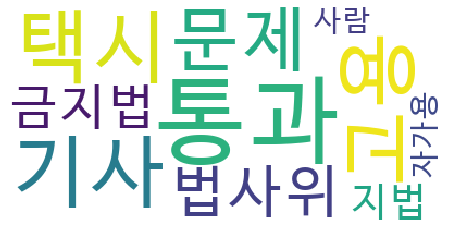

In [114]:
# 워드크라우드. 서버 상에서 한글 글꼴이 깨져 작업 폴더에 D2 coding 폰트 넣음
wordcloud = WordCloud(font_path = 'D2Coding.ttc',relative_scaling=0.5, background_color="white").generate_from_frequencies(result_freq_mc_dict)
plt.figure(figsize=(8,4))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

In [122]:
# 위 결과로 보았을 때 통과, 문제, 기사등이 많이 언급 되었음을 알 수 있다. 
# 택시와 고용 두 단어가 언급 된걸로 보아 택시 기사와 타다 운전자의 고용 문제 대립 관련 얘기가 있지 않을까 추측해본다.

In [116]:
import nltk #파이썬 자연어 처리에서 유명한 패키지라고 한다... 몰랐..
from nltk.probability import FreqDist # 빈도수 구하는 패키지

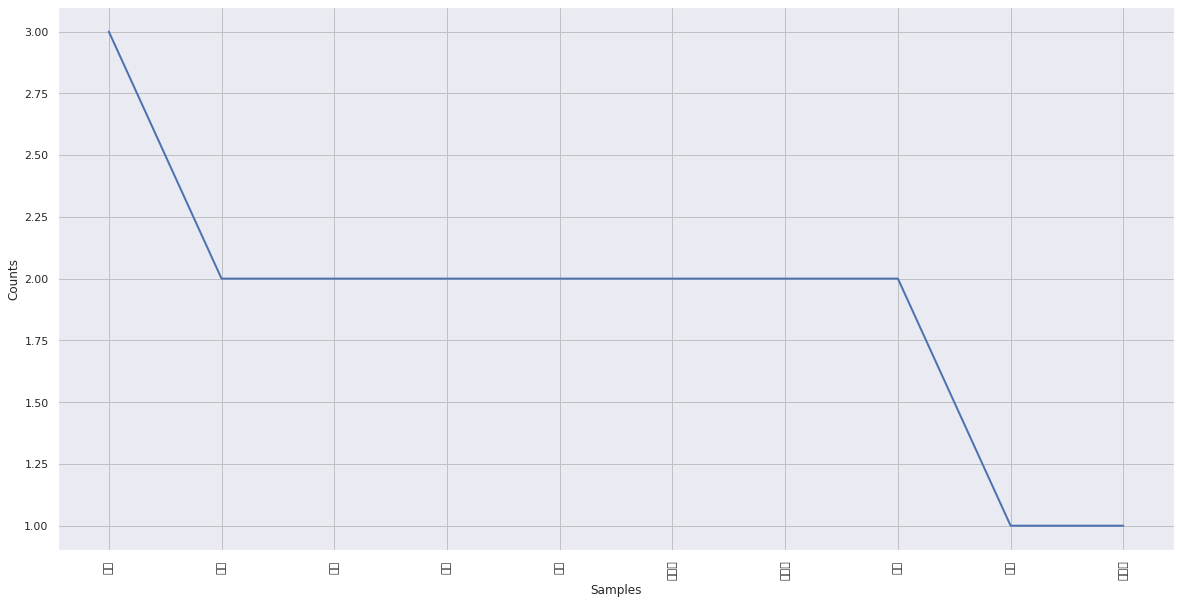

In [121]:
# font는 서버에 d2Coding 설치하면 될듯.... 조금 이따가...
font_location = "D2Coding.ttc"
font_name = font_manager.FontProperties(fname=font_location).get_name()
matplotlib.rc('font',family=font_name)
plt.figure(figsize=(20,10))


graph_comm = FreqDist(rm_dupl) # 두 단어 이상의 글자만 선택한 데이터에서 빈도수 구하고
graph_comm.plot(10) # 그려주기